In [1]:
import math
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_validate,GridSearchCV
import lightgbm as lgb
import seaborn as sns
import numpy as np


# 读取数据

In [2]:
xlsx_file = pd.ExcelFile('./2021-2022_O3&气象五参.xlsx')
sheet_names = xlsx_file.sheet_names
data = pd.DataFrame()

# datat= pd.read_excel('./预测数据.xlsx')
# datat

In [3]:
#得到2021和2022年的数据
df1 = xlsx_file.parse(sheet_names[0])
df2 = xlsx_file.parse(sheet_names[1])
data = pd.concat([df1,df2])
data = data.loc[:, ~data.columns.duplicated()]
data = data.reset_index(drop=True)
# datat.info()

In [38]:
data

,C0007_PNAME,C1705_DATETIME,O3VAL,QIWENVAL,FSVAL,FXVAL,SHIDUVAL,YALIVAL
0,八大关街道,2021-01-01 00:00:00,6.938,-4.038,1.380,134.779,50.243,1029.000
1,八大关街道,2021-01-01 01:00:00,13.344,-3.888,1.255,190.495,49.828,1029.000
2,八大关街道,2021-01-01 02:00:00,11.474,-4.248,1.068,180.058,51.991,1029.000
3,八大关街道,2021-01-01 03:00:00,8.646,-4.650,0.981,216.684,54.268,1028.567
4,八大关街道,2021-01-01 04:00:00,13.963,-4.773,1.014,214.455,52.177,1027.792
...,...,...,...,...,...,...,...,...
105115,珠海街道,2022-12-31 19:00:00,37.291,4.690,0.595,96.414,65.384,1026.644
105116,珠海街道,2022-12-31 20:00:00,18.326,4.228,0.772,51.686,66.851,1027.210
105117,珠海街道,2022-12-31 21:00:00,5.964,3.627,0.967,60.121,67.638,1027.572
105118,珠海街道,2022-12-31 22:00:00,2.345,2.626,0.927,94.954,71.013,1027.736


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105120 entries, 0 to 105119
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   C0007_PNAME     105120 non-null  object        
 1   C1705_DATETIME  105120 non-null  datetime64[ns]
 2   O3VAL           105061 non-null  float64       
 3   QIWENVAL        105077 non-null  float64       
 4   FSVAL           105077 non-null  float64       
 5   FXVAL           105077 non-null  float64       
 6   SHIDUVAL        105077 non-null  float64       
 7   YALIVAL         105077 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.4+ MB


# 特征工程

In [4]:
columns_to_interpolate = ['O3VAL', 'QIWENVAL', 'FSVAL', 'FXVAL', 'SHIDUVAL', 'YALIVAL']
for column in columns_to_interpolate:
        if column in data.columns:
            data[column] = data[column].interpolate(method='linear')

def daypart(hour):
    if hour in [2,3,4,5]:
        return "dawn"
    elif hour in [6,7,8,9]:
        return "morning"
    elif hour in [10,11,12,13]:
        return "noon"
    elif hour in [14,15,16,17]:
        return "afternoon"
    elif hour in [18,19,20,21]:
        return "evening"
    else: return "midnight"

def is_weekend_series(series):
    def is_weekday(date):
        weekday = date.weekday()
        return weekday >= 5

    return series.apply(is_weekday)

In [6]:
from datetime import date 
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(2 * np.pi * x / period))

def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(2 * np.pi * x / period))

cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("day_sin", sin_transformer(7), ["day"]),
        ("day_cos", cos_transformer(7), ["day"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

holidays_2024 = [
    "2024-01-01 00:00:00",  # 元旦
    "2024-02-10 00:00:00",  # 除夕
    "2024-02-11 00:00:00",  # 春节（初一）
    "2024-02-12 00:00:00",  # 春节（初二）
    "2024-02-13 00:00:00",  # 春节（初三）
    "2024-02-14 00:00:00",  # 春节（初四）
    "2024-02-15 00:00:00",  # 春节（初五）
    "2024-02-16 00:00:00",  # 春节（初六）
    "2024-04-04 00:00:00",  # 清明节
    "2024-05-01 00:00:00",  # 劳动节
    "2024-06-10 00:00:00",  # 端午节
    "2024-09-17 00:00:00",  # 中秋节
    "2024-10-01 00:00:00",  # 国庆节
    "2024-10-02 00:00:00",  # 国庆节
    "2024-10-03 00:00:00",  # 国庆节
    "2024-10-04 00:00:00",  # 国庆节
    "2024-10-05 00:00:00",  # 国庆节
    "2024-10-06 00:00:00",  # 国庆节
    "2024-10-07 00:00:00"   # 国庆节
]

data['C1705_DATETIME'] = pd.to_datetime(data['C1705_DATETIME'])
data['year'] = data.C1705_DATETIME.dt.year
data['month'] = data.C1705_DATETIME.dt.month
data['day'] = data.C1705_DATETIME.dt.day
data['hour'] = data.C1705_DATETIME.dt.hour
X_transformed = cyclic_cossin_transformer.fit_transform(data[['month','day','hour']])
X_transformed_df = pd.DataFrame(X_transformed, columns=['month_sin','month_cos','day_sin','day_cos','hour_sin','hour_cos'])
data = pd.concat([data, X_transformed_df], axis=1)
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)

data['quarter']=data['C1705_DATETIME'].dt.quarter
data['hour_section'] = (data['hour'] // 6)
data['diff'] = data['C1705_DATETIME'] - pd.Timestamp('2021-01-01')
data['diff1'] = data['C1705_DATETIME'] - pd.Timestamp('2022-01-01')
half_point = len(data) // 2
data['diff_hours'] = np.where(data.index < half_point, data['diff'].values.astype("timedelta64[h]").astype('int'), 
                              data['diff1'].values.astype("timedelta64[h]").astype('int'))
# print(data['diff_hours'])

data['is_weekend'] = is_weekend_series(data.C1705_DATETIME)
data['day_of_year'] = data.C1705_DATETIME.dt.dayofyear
data['day_of_week'] = data.C1705_DATETIME.dt.dayofweek
data['is_year_start']    = data['C1705_DATETIME'].dt.is_year_start
data['is_year_end']    = data['C1705_DATETIME'].dt.is_year_end
data['is_quarter_start'] = data['C1705_DATETIME'].dt.is_quarter_start 
data['is_quarter_end'] = data['C1705_DATETIME'].dt.is_quarter_end
data['is_month_start']   = data['C1705_DATETIME'].dt.is_month_start 
data['is_month_end']     = data['C1705_DATETIME'].dt.is_month_end
data['day_to_year_start'] = (data['C1705_DATETIME'] - pd.to_datetime(data['C1705_DATETIME'].dt.year, format='%Y')) / pd.Timedelta(days=1)
data['is_holiday'] = data['C1705_DATETIME'].apply(lambda x: 1 if x in holidays_2024 else 0)
day_of_week = data['C1705_DATETIME'].dt.dayofweek
data['day_to_weekend'] = (6 - day_of_week) % 7 

# special_days = ['2021.5.1','2021.10.1',...]

# data['day_of_Week'] = data.C1705_DATETIME.dt.dayofweek
to_one_hot = data['C1705_DATETIME'].dt.day_name()
# second: one hot encode to 7 columns
days = pd.get_dummies(to_one_hot)
#display data
for column in days.columns:
    data[column] = days[column]
    
# raw_dayparts = data['hour'].apply(daypart)
# one hot encoding
# dayparts = pd.get_dummies(raw_dayparts)
# for column in dayparts.columns:
#     data[column] = dayparts[column]


mask = data['O3VAL'] < 0  # 创建一个布尔掩码，表示负值
data.loc[mask, 'O3VAL'] *= -1  # 将负值取反
data1 = data[data['C0007_PNAME']=='兴城路街道']
data2 = data[data['C0007_PNAME']=='北宅街道']
data3 = data[data['C0007_PNAME']=='登州路街道']
data4 = data[data['C0007_PNAME']=='上马街道']
data5 = data[data['C0007_PNAME']=='兴城路街道']

datatrain = data1

import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# 创建一个示例时间序列数据
# dates = pd.date_range(start='2021-01-01 00:00:00',end='2022-12-17 23:00:00',freq='H')
# print(data1[data1['C1705_DATETIME'] == '2021-4-1 00:00:00'])

# ts = pd.Series(scaler.fit_transform(data1.loc[0:82703]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates)


# data1['O3VAL'] = scaler.fit_transform(np.array(data1['O3VAL'].values.reshape(-1, 1)))

# data1['QIWENVAL'] = scaler.fit_transform(np.array(data1['QIWENVAL'].values.reshape(-1, 1)))
# data1['FSVAL'] = scaler.fit_transform(np.array(data1['FSVAL'].values.reshape(-1, 1)))
# data1['FXVAL'] = scaler.fit_transform(np.array(data1['FXVAL'].values.reshape(-1, 1)))
# data1['SHIDUVAL'] = scaler.fit_transform(np.array(data1['SHIDUVAL'].values.reshape(-1, 1)))
# data1['YALIVAL'] = scaler.fit_transform(np.array(data1['YALIVAL'].values.reshape(-1, 1)))

# data1['O3VAL'] = np.sqrt(data1['O3VAL'])

dates = pd.date_range(start='2021-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')
ts = pd.Series(scaler.fit_transform(data1['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates)
# 进行STL分解
stl = STL(ts)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
result = stl.fit()

# dates1 = pd.date_range(start='2022-01-01 00:00:00',end='2022-12-31 23:00:00',freq='H')
# ts1 = pd.Series(scaler.fit_transform(data1.loc[30480:]['O3VAL'].values.reshape(-1, 1)).flatten(), index=dates1)
# # 进行STL分解
# stl1 = STL(ts1)  # seasonal参数表示季节性周期，这里设定为13表示大约一个季度
# result1 = stl1.fit()

# 获取分解后的趋势、季节性和残差
trend = result.trend.values
seasonal = result.seasonal.values
residual = result.resid.values

# 将 arr1 和 arr2 合并成一个大数组
# trend_value = trend.values
# seasonal_value = seasonal.values

# print(len(trend.values))
# print(trend.values[17183])
# for i in range(8424, 8760):
#     trend_value = np.append(trend_value, trend_value[i])
#     seasonal_value = np.append(seasonal_value, seasonal_value[i])
trend_scaled = scaler.fit_transform(np.array(trend.reshape(-1, 1)))
seasonal_scaled = scaler.fit_transform(np.array(seasonal.reshape(-1, 1)))

data1['Trend'] = trend_scaled
data1['Seasonal'] = seasonal_scaled


# residual_value = np.concatenate((residual.values, residual.values))

# 打印合并后的大数组


# Residual_scaled = scaler.fit_transform(np.array(residual_value.reshape(-1, 1)))


# data1['Residual'] = Residual_scaled
# data1['O3_roll_mean_24'] = data1['O3VAL'].rolling(window=24).mean()
# data1['O3_roll_max_24'] = data1['O3VAL'].rolling(window=24).max()
# data1['O3_roll_min_24'] = data1['O3VAL'].rolling(window=24).min()
# print(data1)



C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2075772343.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Trend'] = trend_scaled
C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2075772343.py:167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['Seasonal'] = seasonal_scaled


In [7]:

def add_columns(df):
    for i in range(1, 28*24+1):  # Loop through 1 to 24
        new_col_name = f"O3VAL_{i}"  # New column name based on index
        df[new_col_name] = df['O3VAL'].shift(i)
    # 结束之后
    # df.dropna(axis=0,
    #       how='any',
    #       subset=None,
    #       inplace=True)
    # for i in range(2, 7*24+1):
    #     old_col_name = f"O3VAL_{i-1}"
    #     cur_col_name = f"O3VAL_{i}"
    #     df[cur_col_name] = df[old_col_name] + df[cur_col_name]

    # sum = 0
    # label_sum = 1
    # for i in range(7*24 + 1, 28*24 + 1):
    #     # 构建列名
    #     col_name = f"WEEK_O3VAL_{label_sum}"
    #     del_col_name = f"O3VAL_{i}"
    #     fur_col_name = f"O3VAL_{i + 1}"
    #     if i == 7 * 24 + 7*24+1 or i == 7 * 24 + 14*24+1 or i == 7 * 24 + 21*24:
    #         del_col_name = f"WEEK_O3VAL_{label_sum -1}"
    #     # 累加本周的值
    #     if fur_col_name in df.columns:
    #         df[fur_col_name] = df[del_col_name] + df[fur_col_name]
    #     else:
    #         df[col_name] = df[del_col_name]
    #     del_col_name = f"O3VAL_{i}"
    #     # 计算累加和
    #     sum += 1
        
    #     # 如果累加到一周 (7 * 24 个时间步)
    #     if sum == 7 * 24:
    #         # 构建新特征列
    #         df[col_name] = df[del_col_name]
    #         # 重置累加器
    #         sum = 0
    #         label_sum += 1
    #     df.drop(del_col_name, axis=1, inplace=True)



# Call the function to add columns
add_columns(datatrain)
datatrain.dropna(axis=0,
          how='any',
          subset=None,
          inplace=True)
print(datatrain)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

       C0007_PNAME      C1705_DATETIME   O3VAL  QIWENVAL  FSVAL    FXVAL  \
18048        兴城路街道 2021-01-29 00:00:00  51.178    -6.392  0.425  170.847   
18049        兴城路街道 2021-01-29 01:00:00  36.424    -7.142  0.408  168.255   
18050        兴城路街道 2021-01-29 02:00:00  43.422    -6.832  0.478  210.354   
18051        兴城路街道 2021-01-29 03:00:00  41.524    -6.523  0.465  118.338   
18052        兴城路街道 2021-01-29 04:00:00  29.862    -6.837  0.421  119.355   
...            ...                 ...     ...       ...    ...      ...   
100699       兴城路街道 2022-12-31 19:00:00   3.868     1.720  0.412   83.852   
100700       兴城路街道 2022-12-31 20:00:00   3.748     1.126  0.336  103.761   
100701       兴城路街道 2022-12-31 21:00:00   4.060     0.410  0.356  116.563   
100702       兴城路街道 2022-12-31 22:00:00   3.112    -0.287  0.318  103.541   
100703       兴城路街道 2022-12-31 23:00:00   3.847    -1.119  0.383  165.286   

        SHIDUVAL   YALIVAL  year  month  ...  O3VAL_663  O3VAL_664  O3VAL_665  \
18048 

C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[new_col_name] = df['O3VAL'].shift(i)
C:\Users\lenovo\AppData\Local\Temp\ipykernel_2656\2019975101.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Con

# 数据集划分

In [10]:
# date	O3VAL	QIWENVAL	FSVAL	FXVAL	SHIDUVAL	YALIVAL
import pandas as pd
# 使用切片和字符串拼接将列名从 'O3VAL_1' 到 'O3VAL_72' 构建出来
o3_columns = ['O3VAL_' + str(i) for i in range(1,28*24+1)]
# sta_data = pd.read_csv('sta.csv')
# data1['max_O3'] = data1[o3_columns].max(axis=1)
# data1['min_O3'] = data1[o3_columns].min(axis=1)
# data1['avg_O3'] = data1[o3_columns].mean(axis=1)
# data1['median_O3'] = data1[o3_columns].median(axis=1)
# data1['stddev_O3'] = data1[o3_columns].std(axis=1)
windows_columns = ['max_O3','min_O3','avg_O3','median_O3','stddev_O3']
weekday_columns = ['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']
day_time_columns = ['dawn','morning','noon','afternoon','evening','midnight']
# windows_o3 = ['O3_roll_mean_24','O3_roll_max_24','O3_roll_min_24']
which_day = ['month_sin','month_cos','day_sin','day_cos','hour_sin','hour_cos','diff_hours','hour_section','quarter','is_weekend', 'day_of_year', 'day_of_week',  
               'is_year_start', 'is_year_end', 'is_quarter_start', 'is_quarter_end',
               'is_month_start', 'is_month_end', 'day_to_year_start', 'is_holiday', 'day_to_weekend']
X = datatrain[['year', 'month', 'day', 'hour']+o3_columns+['QIWENVAL'	,'FSVAL'	,'SHIDUVAL'	,'YALIVAL']]
# X = pd.merge(X , sta_data, on=['month', 'day', 'hour'], how='left')
y = datatrain['O3VAL']
# n_rows = int(len(X) * 0.98)

# X['max_O3'] = np.sqrt(X['max_O3'])
# X['min_O3'] = np.sqrt(X['min_O3'])
# X['avg_O3'] = np.sqrt(X['avg_O3'])
# X['median_O3'] = np.sqrt(X['median_O3'])
# X['stddev_O3'] = np.sqrt(X['stddev_O3'])


X_train = X
y_train = y
# x_test = X.loc[82704:]
# y_test = y.loc[82704:]
# print(x_test)
# x_test['Trend'] = X_train.loc[30143:30479]['Trend']
# x_test['Seasonal'] = X_train.loc[30143:30479]['Seasonal']
# x_test['Residual'] = X_train.loc[30143:30479]['Residual']


In [18]:

# print(x_test['year'])
# print(x_test['month'])
# print(X_train.loc[29637:30479])
# print(x_test['Trend'])
# x_test['C1705_DATETIME'] = X_train.loc[29637:30479]['C1705_DATETIME']

# print(X_train[X_train['C1705_DATETIME'] == '2021-11-26 22:00:00'])
# print(x_test['hour'])
# print(x_test['Trend'])

# 训练

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036531 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172452
[LightGBM] [Info] Number of data points in the train set: 16848, number of used features: 680
[LightGBM] [Info] Start training from score 72.351641
{'learning_rate': 0.05, 'reg_alpha': 0} 0.924686715340445
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.041557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 172452
[LightGBM] [Info] Number of data points in the train set: 16848, number of used features: 680
[LightGBM] [Info] Start training from score 72.351641


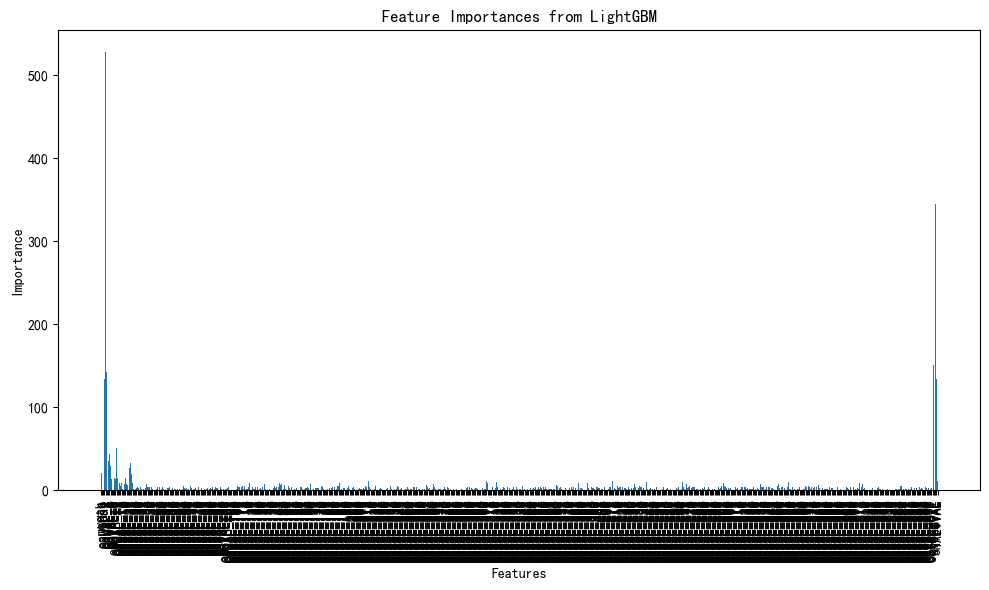

In [12]:


params = {
        'boosting':'gbdt',
        'verbose':0,
        'min_data_in_leaf': 4,
        'objective': 'regression',
        'metric': 'r2',
        'num_leaves': 32,
        'n_estimators':300,
        #'max_bin': 50,
        'max_depth':5,
        "colsample_bytree": 0.8,  # 每次迭代中随机选择特征的比例
        "bagging_fraction": 0.8,  # 每次迭代时用的数据比例
        'n_jobs': 4,
        'silent': 2,  # 信息输出设置成1则没有信息输出
        'seed': 0,
        'bagging_freq':3,
        'is_unbalance':True,
        #'scale_pos_weight': wt
    }  #设置出参数

LGBM=lgb.LGBMRegressor(**params)
scores=cross_validate(LGBM,X_train,y_train,cv=5,scoring='r2',n_jobs=-1)
scores['test_score'].mean()
#网格调参
parameters = {
    "learning_rate": [0.01,0.05,0.1],
    'reg_alpha':[0,2,5,10,15,20]
}
gsearch = GridSearchCV(
    lgb.LGBMRegressor(),
    param_grid=parameters,
    scoring='r2',
    cv=5,
    n_jobs=4)
gsearch.fit(X_train,y_train)
print(gsearch.best_params_, gsearch.best_score_)
best_lgb  = lgb.LGBMRegressor(**gsearch.best_params_)
best_lgb.fit(X_train, y_train)
importance = best_lgb.feature_importances_
best_lgb.booster_.save_model('lgb_first_attempt2_xingcheng.txt')
# 可视化特征重要性
plt.figure(figsize=(10, 6))
plt.bar(range(len(importance)), importance, tick_label=X_train.columns)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances from LightGBM')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



# y_pred = np.array([])
# X_test = x_test.values
# for i, x in enumerate(X_test):
#     y_pred = np.append(y_pred, best_lgb.predict(x.reshape(1, -1)))
#     for j in range(1,min(28*24+1, len(X_test) - i)):  # Loop through 1 to 48
#         X_test[i+j, 3+j] = y_pred[i] 